In [7]:
import matplotlib.pyplot as plt
import numpy as np
from operator import itemgetter

from formulae import fp_location_fsolve, jacobian_numerical_2d, get_physical_fp_stable_and_not, simulate_dynamics_general, \
                     fp_location_general, is_stable, map_init_name_to_init_cond
from constants import BASIN_COLOUR_DICT, NUM_TRAJ, INIT_COND, TIME_START, TIME_END, NUM_STEPS, SIM_METHOD
from params import Params
from presets import presets
from plotting import plot_handler, plot_options_build, plot_trajectory_mono, plot_simplex, plot_trajectory

from trajectory import get_centermanifold_traj

In [8]:
N_range = [int(a) for a in np.logspace(1.50515, 4.13159, num=11)][0:6]  # + [int(a) for a in np.logspace(4.8, 7, num=4)]

presets_to_y0 = {
    'BL1g': 0.14585869420527702,
    'BL100g': 0.22471588735222426,
    'TR1g': 0.19262827700935464,
    'TR100g': 0.28095}

# Linear heuristic for BL1g

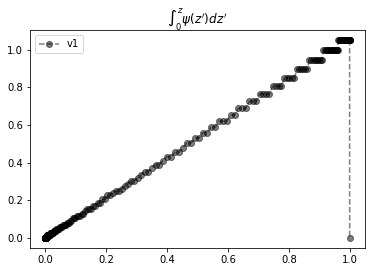

NameError: name 'preset' is not defined

In [9]:
params = presets('BL1g')
f_xyz_arr, s_xyz_arr, z_arr, y_arr = \
    get_centermanifold_traj(params, norm=True, force_region_1=False, force_region_2=False)

def psi_bl1g(z, N):
    s0 = -0.07
    z_norm = z / N
    #return np.exp(s0 * N**2 * (z_norm**2 - z_norm))
    return np.exp(s0 * N * (0.5 * z_norm**2 - z_norm))

def int_psi_bl1g(N, low, high):
    intval = 0.0
    
    z_arr_scaled = z_arr * N
    
    for i, z in enumerate(z_arr_scaled[:-1]):
        if z > high:
            break
        if z >= low:
            dz = z_arr_scaled[i + 1] - z_arr_scaled[i]
            intval += psi_bl1g(z, N) * dz
    return intval

def get_prob_N_from_psi_bl1g(Nval):
    num = int_psi_bl1g(Nval, 0.0, 1.0)
    den = int_psi_bl1g(Nval, 0.0, Nval)
    #print "prob_hit_N_revised", params.N, "num", num
    #print "prob_hit_N_revised", params.N, "den", den
    prob_exit = num / den
    return prob_exit

integral_psi_bl1g_table = np.zeros(len(z_arr))
for i, z in enumerate(z_arr[:-1]):
    zmid = (z_arr[i + 1] + z_arr[i]) / 2
    integral_psi_bl1g_table[i] = int_psi_bl1g(params.N, 0.0, zmid)
   
plt.plot(z_arr, integral_psi_bl1g_table, '--ok', alpha=0.5, label='v1')
plt.title(r"$\int_0^z \psi(z') dz'$")
plt.legend()
#plt.savefig('.png')
plt.show()
plt.close()

prob_N_bl1g = np.zeros(len(N_range))
for idx, Nval in enumerate(N_range):
    prob_N_bl1g[idx] = get_prob_N_from_psi_bl1g(Nval)   
T_bl1g = 1 / (params.mu * params.N * presets_to_y0[preset] * prob_N_bl1g)
print T_bl1g

fs = 12
plt.figure(figsize=(12, 9))
ax = plt.gca()
ax.plot(N_range, curve_orig, ':', marker='p', markeredgecolor='k', color='black',  # colours[idx],
        label=r'%s: $\langle\tau\rangle_{\mathrm{B}}$ Orig' % preset, zorder=3)
ax.plot(N_range, T_bl1g, ':', marker='p', markeredgecolor='k', color='blue',  # colours[idx],
        label=r'%s: $\langle\tau\rangle_{\mathrm{B}}$ BL1g linear heuristic' % preset, zorder=3)

ax.set_xlabel(r'$N$', fontsize=fs)
ax.set_ylabel(r'$\langle\tau\rangle$', fontsize=fs)
plt.xticks(fontsize=fs - 2)
plt.yticks(fontsize=fs - 2)
# plt.legend(bbox_to_anchor=(1.1, 1.05), fontsize=fs-4)
plt.legend(fontsize=fs - 4, ncol=1)
# log options
ax.set_xscale("log")
# ax.set_xlim([np.min(N_range) * 0.9, 1.5 * 1e6])
ax.set_xlim([np.min(N_range) * 0.9, 1.5 * 1e4])
ax.set_yscale("log")
# ax.set_ylim([0.8 * 1e1, 2 * 1e5])
ax.set_ylim([0.8 * 1e2, 2 * 1e6])
plt.show()

In [ ]:
# alt norm version of above cell 
N_range = [int(a) for a in np.logspace(1.50515, 4.13159, num=11)][0:6]

f_xyz_arr, s_xyz_arr, z_arr, y_arr = \
    get_centermanifold_traj(params, norm=True, force_region_1=False, force_region_2=False)

def psi_bl1g(z_norm, N):
    s0 = -0.07
    assert z_norm <= 1
    return np.exp(s0 * N * (z_norm - 0.5 * z_norm**2))

def int_psi_bl1g(N, low, high):
    intval = 0.0
    for i, z in enumerate(N * z_arr[:-1]):
        if z > high:
            break
        if z >= low:
            dz = z_arr[i + 1] - z_arr[i]
            intval += 1 / psi_bl1g(z/N, N) * dz
    return intval

def get_prob_N_from_psi_bl1g(Nval):
    num = int_psi_bl1g(Nval, 0.0, 1.0)
    den = int_psi_bl1g(Nval, 0.0, Nval)
    #print "prob_hit_N_revised", params.N, "num", num
    #print "prob_hit_N_revised", params.N, "den", den
    prob_exit = num / den
    return prob_exit

integral_psi_bl1g_table = np.zeros(len(z_arr))
for i, z in enumerate(z_arr[:-1]):
    zmid = (z_arr[i + 1] + z_arr[i]) / 2
    integral_psi_bl1g_table[i] = int_psi_bl1g(params.N, 0.0, zmid)

plt.plot(np.linspace(0,1,1000), [psi_bl1g(z, 100) for z in np.linspace(0,1,1000)], '--ok', alpha=0.5, label='v1')
plt.title(r"$\psi(z'), N=100$")
plt.legend()
#plt.savefig('.png')
plt.show()
plt.close()
    
plt.plot(z_arr, integral_psi_bl1g_table, '--ok', alpha=0.5, label='v1')
plt.title(r"$\int_0^z \psi(z') dz'$")
plt.legend()
#plt.savefig('.png')
plt.show()
plt.close()

prob_N_bl1g = np.zeros(len(N_range))
T_bl1g = np.zeros(len(N_range))
T_guess = np.zeros(len(N_range))
for idx, Nval in enumerate(N_range):
    ratefactor = params.mu * Nval * presets_to_y0[preset]
    prob_N_bl1g[idx] = get_prob_N_from_psi_bl1g(Nval)   
    T_bl1g[idx] = 1 / (ratefactor * prob_N_bl1g[idx])
    T_guess[idx] = 1 / (ratefactor * np.exp(-0.07 * Nval))

fs = 12
plt.figure(figsize=(12, 9))
ax = plt.gca()
ax.plot(N_range, curve_orig, ':', marker='p', markeredgecolor='k', color='black',  # colours[idx],
        label=r'%s: $\langle\tau\rangle_{\mathrm{B}}$ Orig' % preset, zorder=3)
ax.plot(N_range, T_bl1g, ':', marker='p', markeredgecolor='k', color='blue',  # colours[idx],
        label=r'%s: $\langle\tau\rangle_{\mathrm{B}}$ BL1g linear heuristic' % preset, zorder=3)

ax.plot(N_range, T_guess, ':', marker='^', markeredgecolor='k', color='green',  # colours[idx],
        label=r'%s: $\langle\tau\rangle_{\mathrm{B}}$ fit' % preset, zorder=3)


ax.set_xlabel(r'$N$', fontsize=fs)
ax.set_ylabel(r'$\langle\tau\rangle$', fontsize=fs)
plt.xticks(fontsize=fs - 2)
plt.yticks(fontsize=fs - 2)
# plt.legend(bbox_to_anchor=(1.1, 1.05), fontsize=fs-4)
plt.legend(fontsize=fs - 4, ncol=1)
# log options
ax.set_xscale("log")
# ax.set_xlim([np.min(N_range) * 0.9, 1.5 * 1e6])
ax.set_xlim([np.min(N_range) * 0.9, 1.5 * 1e4])
ax.set_yscale("log")
# ax.set_ylim([0.8 * 1e1, 2 * 1e5])
#ax.set_ylim([0.8 * 1e2, 2 * 1e6])
plt.show()

# USING SCIPY QUAD

In [10]:
from scipy.integrate import quad

def A_over_B(z):
    s0 = -0.07
    s_of_z = s0 * (1 - z)        
    return s_of_z / 2.0

def psi(upper, N):
    return np.exp(2 * N * quad(A_over_B, 0, upper)[0])
    
def integral_of_psi(N, lower, upper):
    return quad(psi, lower, upper, args=(N))[0]

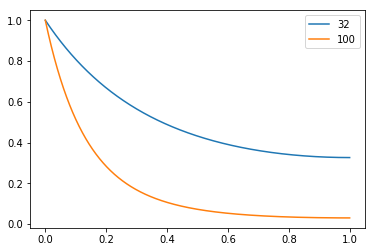

In [11]:
zrange = np.linspace(0,1,1000)
psi_table_32 = [psi(z,32) for z in zrange]
psi_table_100 = [psi(z,100) for z in zrange]

plt.plot(zrange, psi_table_32, label='32')
plt.plot(zrange, psi_table_100, label='100')
plt.legend()
plt.show()

In [12]:
"""
def get_time_from_Nval(N):
    prob_N = integral_of_psi(N, 0, 1.0/N) / integral_of_psi(N, 0, 1)
    rate_0 = 10**(-4) * 0.17 * N
    return 1/(prob_N * rate_0)
"""

'\ndef get_time_from_Nval(N):\n    prob_N = integral_of_psi(N, 0, 1.0/N) / integral_of_psi(N, 0, 1)\n    rate_0 = 10**(-4) * 0.17 * N\n    return 1/(prob_N * rate_0)\n'

# With feedback (PW linear)

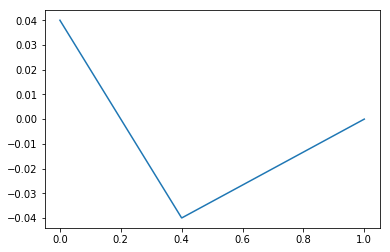

In [13]:
def A_over_B(z, label):
    assert z<=1.0
    if label == 'BL1g':
        s0 = -0.07
        s_of_z = s0 * (1 - z)
    if label == 'TR1g':
        s0 = +0.06
        s_of_z = s0 * (1 - z)
    if label == 'BL100g':
        s0 = -0.06
        s1 = 0.05
        z1 = 0.4
        if z < z1:
            s_of_z = s0 + (s1-s0) * z/z1
        else:
            s_of_z = s1 * (1-z) / (1-z1)
    if label == 'TR100g':
        s0 = 0.04
        s1 = -0.04
        z1 = 0.4
        if z < z1:
            s_of_z = s0 + (s1-s0) * z/z1
        else:
            s_of_z = s1 * (1-z) / (1-z1)
    return s_of_z / 2.0

zrange = np.linspace(0,1,1000)
plt.plot(zrange, [2*A_over_B(z, 'TR100g') for z in zrange])

In [14]:
def psi_inv(upper, N, label):
    return np.exp(-1 * 2 * N * quad(A_over_B, 0, upper, args=label)[0])

def psi_inv_byhand(z, N, label):
    assert z<=1.0
    if label == 'BL1g':
        s0 = -0.07
        psi_inv = np.exp( - s0 * N * (z - 0.5 * z**2))
    if label == 'TR1g':
        s0 = +0.06
        psi_inv = np.exp(- s0 * N * (z - 0.5 * z**2))
    if label == 'BL100g':
        s0 = -0.06
        s1 = 0.05
        z1 = 0.4
        if z < z1:
            psi_inv = np.exp(- N * (s0 * z + 0.5 * (s1 - s0) * z**2 / z1))
        else:
            psi_z1_inv = np.exp(- N * z1 * (s1+s0) / 2)
            psi_inv = psi_z1_inv * np.exp(- s1 * N * (z - z1)/(1-z1) * (1 - 0.5*(z+z1)))
    if label == 'TR100g':
        s0 = 0.04
        s1 = -0.04
        z1 = 0.4
        if z < z1:
            psi_inv = np.exp(- N * (s0 * z + 0.5 * (s1-s0) * z**2 / z1))
        else:
            psi_z1_inv = np.exp(- N * z1 * (s1+s0) / 2)
            psi_inv = psi_z1_inv * np.exp(- s1 * N * (z - z1)/(1-z1) * (1 - 0.5*(z+z1)))
    return psi_inv

    
def integral_of_psi_inv(N, lower, upper, label):
    #return quad(psi_inv, lower, upper, args=(N, label))[0]
    return quad(psi_inv_byhand, lower, upper, args=(N, label))[0]
    

def get_time_from_Nval(N, label):
    prob_N = integral_of_psi_inv(N, 0, 1.0/N, label) / integral_of_psi_inv(N, 0, 1, label)
    rate_0 = 10**(-4) * presets_to_y0[label] * N
    return 1/(prob_N * rate_0)

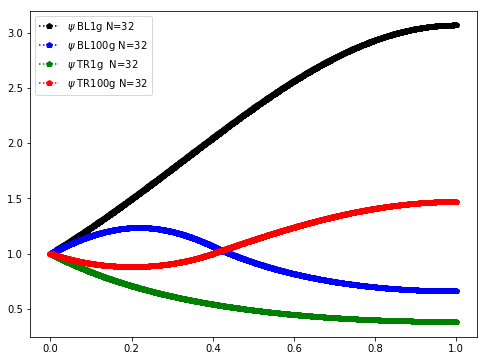

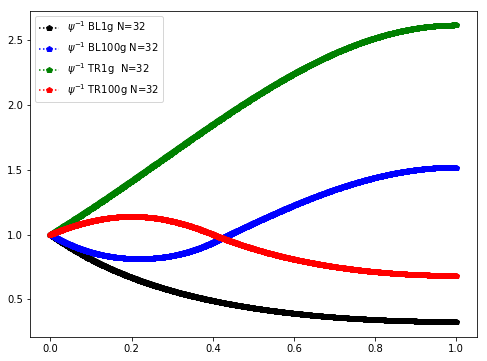

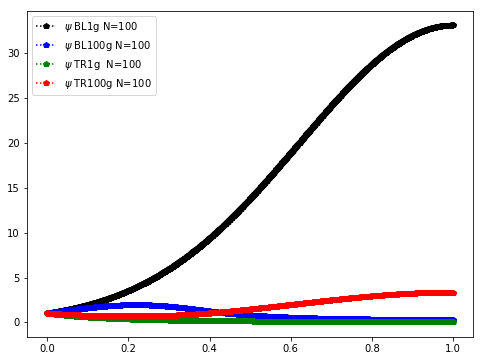

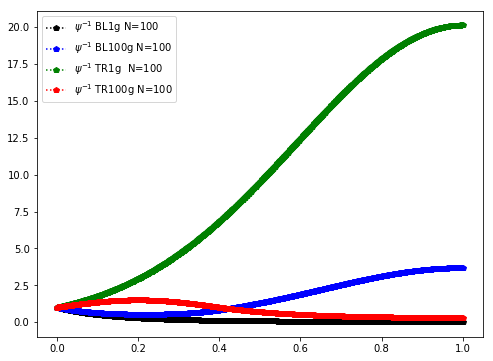

In [15]:
# plot the psi's (via auto integration)

N0 = 32
zrange = np.linspace(0,1,1000)
psi_curve_BL1 = np.array([psi_inv(z, N0, 'BL1g') for z in zrange])
psi_curve_BL100 = np.array([psi_inv(z, N0, 'BL100g') for z in zrange])
psi_curve_TR1 = np.array([psi_inv(z, N0, 'TR1g') for z in zrange])
psi_curve_TR100 = np.array([psi_inv(z, N0, 'TR100g') for z in zrange])

fs = 16

plt.figure(figsize=(8, 6))
ax = plt.gca()
ax.plot(zrange, psi_curve_BL1, ':', marker='p', markeredgecolor=None, color='black',  # colours[idx],
        label=r'$\psi$ BL1g N=%d' % N0, zorder=3)
ax.plot(zrange, psi_curve_BL100, ':', marker='p', markeredgecolor=None, color='blue',  # colours[idx],
        label=r'$\psi$ BL100g N=%d' % N0, zorder=3)
ax.plot(zrange, psi_curve_TR1, ':', marker='p', markeredgecolor=None, color='green',  # colours[idx],
        label=r'$\psi$ TR1g  N=%d' % N0, zorder=3)
ax.plot(zrange, psi_curve_TR100, ':', marker='p', markeredgecolor=None, color='red',  # colours[idx],
        label=r'$\psi$ TR100g N=%d' % N0, zorder=3)
plt.legend()
plt.show()
plt.close()

plt.figure(figsize=(8, 6))
ax = plt.gca()
ax.plot(zrange, 1/psi_curve_BL1, ':', marker='p', markeredgecolor=None, color='black',  # colours[idx],
        label=r'$\psi^{-1}$ BL1g N=%d' % N0, zorder=3)
ax.plot(zrange, 1/psi_curve_BL100, ':', marker='p', markeredgecolor=None, color='blue',  # colours[idx],
        label=r'$\psi^{-1}$ BL100g N=%d' % N0, zorder=3)
ax.plot(zrange, 1/psi_curve_TR1, ':', marker='p', markeredgecolor=None, color='green',  # colours[idx],
        label=r'$\psi^{-1}$ TR1g  N=%d' % N0, zorder=3)
ax.plot(zrange, 1/psi_curve_TR100, ':', marker='p', markeredgecolor=None, color='red',  # colours[idx],
        label=r'$\psi^{-1}$ TR100g N=%d' % N0, zorder=3)
plt.legend()
plt.show()
plt.close()

N0 = 100
zrange = np.linspace(0,1,1000)
psi_curve_BL1 = np.array([psi_inv(z, N0, 'BL1g') for z in zrange])
psi_curve_BL100 = np.array([psi_inv(z, N0, 'BL100g') for z in zrange])
psi_curve_TR1 = np.array([psi_inv(z, N0, 'TR1g') for z in zrange])
psi_curve_TR100 = np.array([psi_inv(z, N0, 'TR100g') for z in zrange])

plt.figure(figsize=(8, 6))
ax = plt.gca()
ax.plot(zrange, psi_curve_BL1, ':', marker='p', markeredgecolor=None, color='black',  # colours[idx],
        label=r'$\psi$ BL1g N=%d' % N0, zorder=3)
ax.plot(zrange, psi_curve_BL100, ':', marker='p', markeredgecolor=None, color='blue',  # colours[idx],
        label=r'$\psi$ BL100g N=%d' % N0, zorder=3)
ax.plot(zrange, psi_curve_TR1, ':', marker='p', markeredgecolor=None, color='green',  # colours[idx],
        label=r'$\psi$ TR1g  N=%d' % N0, zorder=3)
ax.plot(zrange, psi_curve_TR100, ':', marker='p', markeredgecolor=None, color='red',  # colours[idx],
        label=r'$\psi$ TR100g N=%d' % N0, zorder=3)
plt.legend()
plt.show()
plt.close()

plt.figure(figsize=(8, 6))
ax = plt.gca()
ax.plot(zrange, 1/psi_curve_BL1, ':', marker='p', markeredgecolor=None, color='black',  # colours[idx],
        label=r'$\psi^{-1}$ BL1g N=%d' % N0, zorder=3)
ax.plot(zrange, 1/psi_curve_BL100, ':', marker='p', markeredgecolor=None, color='blue',  # colours[idx],
        label=r'$\psi^{-1}$ BL100g N=%d' % N0, zorder=3)
ax.plot(zrange, 1/psi_curve_TR1, ':', marker='p', markeredgecolor=None, color='green',  # colours[idx],
        label=r'$\psi^{-1}$ TR1g  N=%d' % N0, zorder=3)
ax.plot(zrange, 1/psi_curve_TR100, ':', marker='p', markeredgecolor=None, color='red',  # colours[idx],
        label=r'$\psi^{-1}$ TR100g N=%d' % N0, zorder=3)
plt.legend()
plt.show()
plt.close()


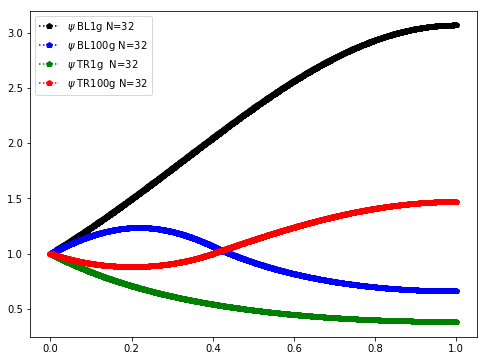

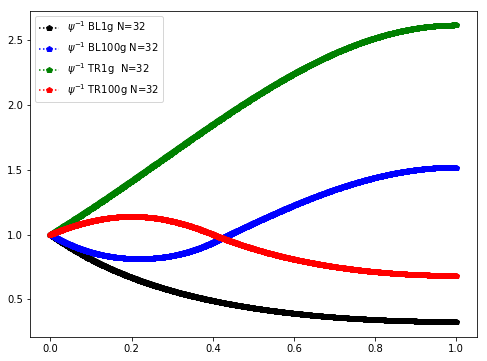

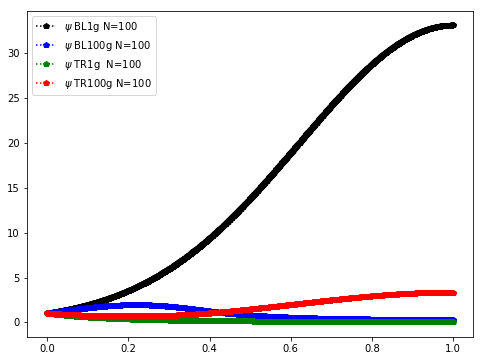

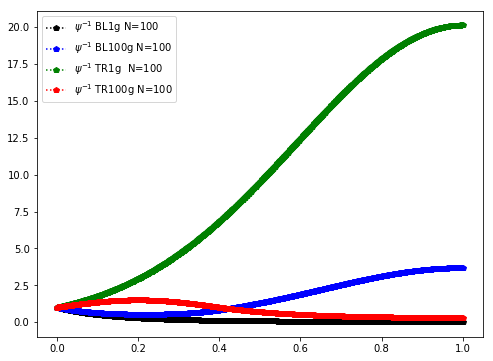

In [16]:
# plot the psi's (by hand integration)

N0 = 32
zrange = np.linspace(0,1,1000)
psi_curve_BL1 = np.array([psi_inv_byhand(z, N0, 'BL1g') for z in zrange])
psi_curve_BL100 = np.array([psi_inv_byhand(z, N0, 'BL100g') for z in zrange])
psi_curve_TR1 = np.array([psi_inv_byhand(z, N0, 'TR1g') for z in zrange])
psi_curve_TR100 = np.array([psi_inv_byhand(z, N0, 'TR100g') for z in zrange])

fs = 16

plt.figure(figsize=(8, 6))
ax = plt.gca()
ax.plot(zrange, psi_curve_BL1, ':', marker='p', markeredgecolor=None, color='black',  # colours[idx],
        label=r'$\psi$ BL1g N=%d' % N0, zorder=3)
ax.plot(zrange, psi_curve_BL100, ':', marker='p', markeredgecolor=None, color='blue',  # colours[idx],
        label=r'$\psi$ BL100g N=%d' % N0, zorder=3)
ax.plot(zrange, psi_curve_TR1, ':', marker='p', markeredgecolor=None, color='green',  # colours[idx],
        label=r'$\psi$ TR1g  N=%d' % N0, zorder=3)
ax.plot(zrange, psi_curve_TR100, ':', marker='p', markeredgecolor=None, color='red',  # colours[idx],
        label=r'$\psi$ TR100g N=%d' % N0, zorder=3)
plt.legend()
plt.show()
plt.close()

plt.figure(figsize=(8, 6))
ax = plt.gca()
ax.plot(zrange, 1/psi_curve_BL1, ':', marker='p', markeredgecolor=None, color='black',  # colours[idx],
        label=r'$\psi^{-1}$ BL1g N=%d' % N0, zorder=3)
ax.plot(zrange, 1/psi_curve_BL100, ':', marker='p', markeredgecolor=None, color='blue',  # colours[idx],
        label=r'$\psi^{-1}$ BL100g N=%d' % N0, zorder=3)
ax.plot(zrange, 1/psi_curve_TR1, ':', marker='p', markeredgecolor=None, color='green',  # colours[idx],
        label=r'$\psi^{-1}$ TR1g  N=%d' % N0, zorder=3)
ax.plot(zrange, 1/psi_curve_TR100, ':', marker='p', markeredgecolor=None, color='red',  # colours[idx],
        label=r'$\psi^{-1}$ TR100g N=%d' % N0, zorder=3)
plt.legend()
plt.show()
plt.close()

N0 = 100
zrange = np.linspace(0,1,1000)
psi_curve_BL1 = np.array([psi_inv_byhand(z, N0, 'BL1g') for z in zrange])
psi_curve_BL100 = np.array([psi_inv_byhand(z, N0, 'BL100g') for z in zrange])
psi_curve_TR1 = np.array([psi_inv_byhand(z, N0, 'TR1g') for z in zrange])
psi_curve_TR100 = np.array([psi_inv_byhand(z, N0, 'TR100g') for z in zrange])

plt.figure(figsize=(8, 6))
ax = plt.gca()
ax.plot(zrange, psi_curve_BL1, ':', marker='p', markeredgecolor=None, color='black',  # colours[idx],
        label=r'$\psi$ BL1g N=%d' % N0, zorder=3)
ax.plot(zrange, psi_curve_BL100, ':', marker='p', markeredgecolor=None, color='blue',  # colours[idx],
        label=r'$\psi$ BL100g N=%d' % N0, zorder=3)
ax.plot(zrange, psi_curve_TR1, ':', marker='p', markeredgecolor=None, color='green',  # colours[idx],
        label=r'$\psi$ TR1g  N=%d' % N0, zorder=3)
ax.plot(zrange, psi_curve_TR100, ':', marker='p', markeredgecolor=None, color='red',  # colours[idx],
        label=r'$\psi$ TR100g N=%d' % N0, zorder=3)
plt.legend()
plt.show()
plt.close()

plt.figure(figsize=(8, 6))
ax = plt.gca()
ax.plot(zrange, 1/psi_curve_BL1, ':', marker='p', markeredgecolor=None, color='black',  # colours[idx],
        label=r'$\psi^{-1}$ BL1g N=%d' % N0, zorder=3)
ax.plot(zrange, 1/psi_curve_BL100, ':', marker='p', markeredgecolor=None, color='blue',  # colours[idx],
        label=r'$\psi^{-1}$ BL100g N=%d' % N0, zorder=3)
ax.plot(zrange, 1/psi_curve_TR1, ':', marker='p', markeredgecolor=None, color='green',  # colours[idx],
        label=r'$\psi^{-1}$ TR1g  N=%d' % N0, zorder=3)
ax.plot(zrange, 1/psi_curve_TR100, ':', marker='p', markeredgecolor=None, color='red',  # colours[idx],
        label=r'$\psi^{-1}$ TR100g N=%d' % N0, zorder=3)
plt.legend()
plt.show()
plt.close()


In [17]:
N_range = [int(a) for a in np.logspace(1.50515, 4.13159, num=11)]  # + [int(a) for a in np.logspace(4.8, 7, num=4)]

timecurve_BL1 = [get_time_from_Nval(Nval, 'BL1g') for Nval in N_range]
timecurve_BL100 = [get_time_from_Nval(Nval, 'BL100g') for Nval in N_range]
timecurve_TR1 = [get_time_from_Nval(Nval, 'TR1g') for Nval in N_range]
timecurve_TR100 = [get_time_from_Nval(Nval, 'TR100g') for Nval in N_range]

def BL1_build(Nval):
    from scipy.special import erf
    s0 = -0.07
    a = np.abs(s0) * Nval / 2.0
    I_of_N = np.sqrt(np.pi/2) / np.sqrt(2 * a) * np.exp(a) * erf(np.sqrt(a))
    rate_0 = 10**(-4) * presets_to_y0['BL1g']
    return np.exp(s0) / (rate_0) * I_of_N

def TR1_build(Nval):
    from scipy.special import erfi
    s0 = +0.06
    a = s0 * Nval / 2.0
    I_of_N = np.sqrt(np.pi/2) / np.sqrt(2 * a) * np.exp(-a) * erfi(np.sqrt(a))
    rate_0 = 10**(-4) * presets_to_y0['TR1g']
    return np.exp(s0) / (rate_0) * I_of_N

timecurve_BL1_build = [BL1_build(Nval) for Nval in N_range]
timecurve_TR1_build = [TR1_build(Nval) for Nval in N_range]

print "timecurve_BL1_build", timecurve_BL1_build
print "timecurve_TR1_build", timecurve_TR1_build



timecurve_BL1_build [142000.3549886837, 289454.51884172566, 1230880.983509889, 20616642.21123776, 4576576135.186831, 118540554646994.77, 1.8073998185736947e+22, 2.19407857819616e+37, 1.1805394140105981e+65, 8.973836921430183e+115, 1.630569657568212e+209]
timecurve_TR1_build [30348.307104303396, 19993.65989633394, 10733.202500855401, 5277.106443530732, 2700.7939530372023, 1434.7149520144376, 773.4454081963862, 419.687901659014, 228.41440433161884, 124.5181270431482, 67.94164647443668]


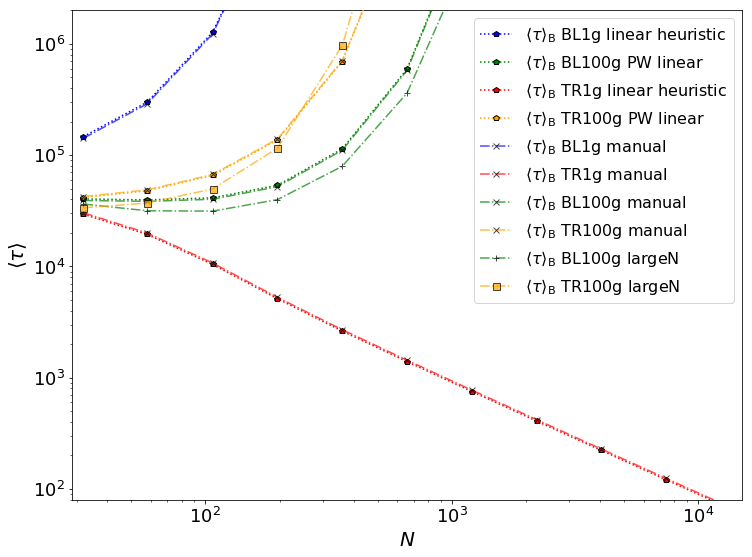

In [42]:
fs = 20
plt.figure(figsize=(12, 9))
ax = plt.gca()
#ax.plot(N_range, curve_orig, ':', marker='p', markeredgecolor='k', color='black',  # colours[idx],
#        label=r'$\langle\tau\rangle_{\mathrm{B}}$ Orig (BL1g)', zorder=3)
ax.plot(N_range, timecurve_BL1, ':', marker='p', markeredgecolor='k', color='blue',  # colours[idx],
        label=r'$\langle\tau\rangle_{\mathrm{B}}$ BL1g linear heuristic', zorder=3)
ax.plot(N_range, timecurve_BL100, ':', marker='p', markeredgecolor='k', color='green',  # colours[idx],
        label=r'$\langle\tau\rangle_{\mathrm{B}}$ BL100g PW linear', zorder=3)
ax.plot(N_range, timecurve_TR1, ':', marker='p', markeredgecolor='k', color='red',  # colours[idx],
        label=r'$\langle\tau\rangle_{\mathrm{B}}$ TR1g linear heuristic', zorder=3)
ax.plot(N_range, timecurve_TR100, ':', marker='p', markeredgecolor='k', color='orange',  # colours[idx],
        label=r'$\langle\tau\rangle_{\mathrm{B}}$ TR100g PW linear', zorder=3)

ax.plot(N_range, timecurve_BL1_build, '-.', marker='x', markeredgecolor='k', color='blue',  # colours[idx],
        label=r'$\langle\tau\rangle_{\mathrm{B}}$ BL1g manual', zorder=3, alpha=0.7)
ax.plot(N_range, timecurve_TR1_build, '-.', marker='x', markeredgecolor='k', color='red',  # colours[idx],
        label=r'$\langle\tau\rangle_{\mathrm{B}}$ TR1g manual', zorder=3, alpha=0.7)

ax.plot(N_range, timecurve_BL100_build, '-.', marker='x', markeredgecolor='k', color='green',  # colours[idx],
        label=r'$\langle\tau\rangle_{\mathrm{B}}$ BL100g manual', zorder=3, alpha=0.7)
ax.plot(N_range, timecurve_TR100_build, '-.', marker='x', markeredgecolor='k', color='orange',  # colours[idx],
        label=r'$\langle\tau\rangle_{\mathrm{B}}$ TR100g manual', zorder=3, alpha=0.7)



# compare manually computed integrals shown in the SI
#################################################
C4 = 1.3
s04 = -0.06
s14 = 0.05
from scipy import special
feedback_4_byhand = [2 * np.sqrt(np.pi * C4 / N) * np.exp(N * C4**2 * (s04)**2) for N in N_range]
#feedback_4_byhand_full = [np.sqrt(np.pi * C4 / N) * np.exp(N * C4**2 * (s04)**2) * 
#                          (special.erf(np.abs(s04) * np.sqrt(N) *C4) + special.erf(np.abs(s14) * np.sqrt(N) *C4)) for N in N_range]
BL100_byhand = [np.exp(s04) * feedback_4_byhand[idx] / (10**(-4) * presets_to_y0['BL100g']) for idx in xrange(len(N_range))]

ax.plot(N_range, BL100_byhand, '-.', marker='+', markeredgecolor='k', color='green',  # colours[idx],
        label=r'$\langle\tau\rangle_{\mathrm{B}}$ BL100g largeN', zorder=3, alpha=0.7)
#################################################

#################################################
s03 = 0.04
s13 = -0.04
z13 = 0.4
from scipy import special
#feedback_3_byhand = [(1/np.sqrt(2) * np.abs(s13) * N) * np.exp(N * np.abs(s13) / (1-z13) * (z13 - 0.5 + (1-z13)**2)) for N in N_range]
feedback_3_byhand_full = [np.sqrt(np.pi * (1-z13) / (2 * N * np.abs(s13))) * np.exp(N * np.abs(s13) / (1-z13) * (z13 - 0.5*(1+s13**2))) 
                          * special.erfi(np.sqrt(N * np.abs(s13) * (1-z13))) for N in N_range]


TR100_byhand = [np.exp(s03) * feedback_3_byhand_full[idx] / (10**(-4) * presets_to_y0['TR100g']) for idx in xrange(len(N_range))]
ax.plot(N_range, TR100_byhand, '-.', markersize=7, marker='s', markeredgecolor='k', color='orange',  # colours[idx],
        label=r'$\langle\tau\rangle_{\mathrm{B}}$ TR100g largeN', zorder=3, alpha=0.7)
#################################################



ax.set_xlabel(r'$N$', fontsize=fs)
ax.set_ylabel(r'$\langle\tau\rangle$', fontsize=fs)
plt.xticks(fontsize=fs - 2)
plt.yticks(fontsize=fs - 2)
# plt.legend(bbox_to_anchor=(1.1, 1.05), fontsize=fs-4)
plt.legend(fontsize=fs - 4, ncol=1)

# log options
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim([np.min(N_range) * 0.9, 1.5 * 1e4])
ax.set_ylim([0.8 * 1e2, 2 * 1e6])
plt.savefig('taubHeuristics.pdf')
plt.show()

In [ ]:
aa = np.array(timecurve_BL1) - np.array(timecurve_BL1_build)
print aa


In [ ]:
from scipy.special import erfi
erfi(1.999)

# Manual check of the psi integrals in feedback case

In [20]:
def integrand_left(z, N, label):
    if label == 'BL100g':
        s0 = -0.06
        s1 = 0.05
        z1 = 0.4
    if label == 'TR100g':
        s0 = 0.04
        s1 = -0.04
        z1 = 0.4
    assert z <= z1
    bigfactor = (s1-s0)/(2*z1) * z**2 + z * s0
    return np.exp(- N * bigfactor)
    
    
def integrand_right(z, N, label):
    if label == 'BL100g':
        s0 = -0.06
        s1 = 0.05
        z1 = 0.4
    if label == 'TR100g':
        s0 = 0.04
        s1 = -0.04
        z1 = 0.4
    assert z >= z1
    bigfactor = s1 * (z-z1)/(1-z1) * (1 - 0.5*(z + z1))
    return np.exp(- N * bigfactor)


def get_time_from_Nval_feedback(N, label):
    if label == 'BL100g':
        s0 = -0.06
        s1 = 0.05
        z1 = 0.4
    if label == 'TR100g':
        s0 = 0.04
        s1 = -0.04
        z1 = 0.4
    int_left = quad(integrand_left, 0, z1, args=(N, label))[0]
    int_right = quad(integrand_right, z1, 1, args=(N, label))[0]
    factor_right = np.exp(-N * (s1 + s0) * z1 / 2)
    int_overall = int_left + factor_right * int_right
    
    rate_0 = 10**(-4) * presets_to_y0[label]
    mfpt = 1 / (rate_0) * np.exp(s0) * int_overall
    
    return mfpt

In [21]:
N_range = [int(a) for a in np.logspace(1.50515, 4.13159, num=11)]  # + [int(a) for a in np.logspace(4.8, 7, num=4)]

timecurve_BL100_build = [get_time_from_Nval_feedback(Nval, 'BL100g') for Nval in N_range]
timecurve_TR100_build = [get_time_from_Nval_feedback(Nval, 'TR100g') for Nval in N_range]

print "timecurve_BL100_build", timecurve_BL100_build
print "timecurve_TR100_build", timecurve_TR100_build



timecurve_BL100_build [39165.61611250597, 38462.00306609713, 40166.14414208787, 52102.15749615543, 110710.43085234592, 579431.2200607181, 15368974.15057252, 7958403226.86762, 955163928668212.6, 2.447345181396894e+24, 5.2800988931568114e+41]
timecurve_TR100_build [42513.04938806633, 48810.234601608405, 67163.56359672776, 139932.32021622985, 709013.2493943275, 18835485.229787607, 9868543090.59604, 1201404022708441.5, 3.170270599794334e+24, 7.238882808463546e+41, 5.5977165395143486e+73]


In [ ]:
from data_io import write_mfpt_heuristic

write_mfpt_heuristic(N_range, timecurve_BL1_build, filename_mod="_BL1g_tauBintegral")
write_mfpt_heuristic(N_range, timecurve_BL100_build, filename_mod="_BL100g_tauBintegral")
write_mfpt_heuristic(N_range, timecurve_TR1_build, filename_mod="_TR1g_tauBintegral")
write_mfpt_heuristic(N_range, timecurve_TR100_build, filename_mod="_TR100g_tauBintegral")
